In [18]:
import pandas as pd

df = pd.read_csv('negative.csv', na_values=['NULL'])

df['AcquisitionDateTime_DT'] = pd.to_datetime(df['AcquisitionDateTime_DT'])

print(df.head())

print(df.info())
print(df.isnull().sum())

  PatientID                                     12SL_Codes Source  \
0   HR00001                                        22,1684  PTBXL   
1   HR00002                      21,542,1665,531,1666,1693  PTBXL   
2   HR00003                                        22,1684  PTBXL   
3   HR00004  19,177,222,177,246,380,542,1665,533,1666,1693  PTBXL   
4   HR00005                                        22,1684  PTBXL   

             Phys_Codes  MI_12SL  MI_Phys  TestID  PatientAge  Gender  \
0  251146004, 426783006        0        0       1         NaN     NaN   
1  426177001, 426783006        0        0       2         NaN     NaN   
2             426783006        0        0       3         NaN     NaN   
3             426783006        0        0       4         NaN     NaN   
4             426783006        0        0       5         NaN     NaN   

  AcquisitionDateTime_DT  ...  STDOWN_V6  STELEV_V6  JELEV_V6  DLTWV_V6  \
0    2020-04-23 07:59:54  ...          2          4         0         0

In [19]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


In [20]:
y = df['MI_Phys']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys']), y, test_size=0.2, random_state=42)

y_12SL = X_test['MI_12SL']

#drop the 12SL column
X_test = X_test.drop(columns=['MI_12SL'])
X_train = X_train.drop(columns=['MI_12SL'])


In [21]:
#count number of positive and negative smales based on MI_Phys
print(df['MI_Phys'].value_counts())

MI_Phys
0    63927
1     3968
Name: count, dtype: int64


In [22]:
estimators = [0.15, 0.11, 0.1, 0.09, 0.08, 0.07]
leaves = [15, 31, 63, 127]
scores = {}
for estims in estimators:
    for num_leaves in leaves:
        lgb_params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'n_estimators': 100,
            'learning_rate': estims,
            'random_state': 42,
            'verbose': -1,
            'num_leaves': num_leaves,
            #'scale_pos_weight': 63927/3968,
            #'is_unbalance': True
            }
        model = (lgb.LGBMClassifier(**lgb_params))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='micro')
        scores[(estims, num_leaves)] = score
        print(f"Learning rate: {estims}, Number of Leaves: {num_leaves} F1 score: {score:.4f}")

Learning rate: 0.15, Number of Leaves: 15 F1 score: 0.9540
Learning rate: 0.15, Number of Leaves: 31 F1 score: 0.9550
Learning rate: 0.15, Number of Leaves: 63 F1 score: 0.9548
Learning rate: 0.15, Number of Leaves: 127 F1 score: 0.9548
Learning rate: 0.11, Number of Leaves: 15 F1 score: 0.9553
Learning rate: 0.11, Number of Leaves: 31 F1 score: 0.9548
Learning rate: 0.11, Number of Leaves: 63 F1 score: 0.9557
Learning rate: 0.11, Number of Leaves: 127 F1 score: 0.9549
Learning rate: 0.1, Number of Leaves: 15 F1 score: 0.9544
Learning rate: 0.1, Number of Leaves: 31 F1 score: 0.9546
Learning rate: 0.1, Number of Leaves: 63 F1 score: 0.9551
Learning rate: 0.1, Number of Leaves: 127 F1 score: 0.9558
Learning rate: 0.09, Number of Leaves: 15 F1 score: 0.9549
Learning rate: 0.09, Number of Leaves: 31 F1 score: 0.9562
Learning rate: 0.09, Number of Leaves: 63 F1 score: 0.9549
Learning rate: 0.09, Number of Leaves: 127 F1 score: 0.9554
Learning rate: 0.08, Number of Leaves: 15 F1 score: 0.95

In [23]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.15,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 127,
    'scale_pos_weight': 63927/3968,
    #'is_unbalance': True

    }
model = (lgb.LGBMClassifier(**lgb_params))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print("Final F1 score: ", score)





Final F1 score:  0.9569924147580824


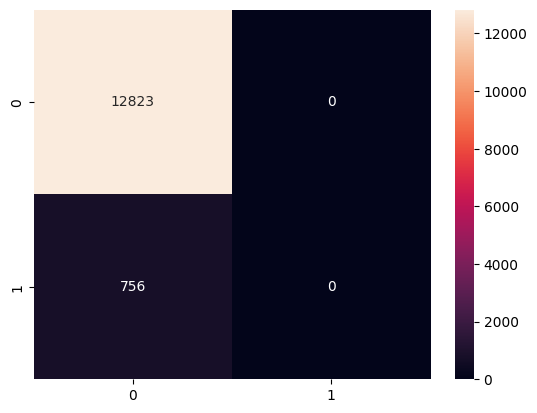

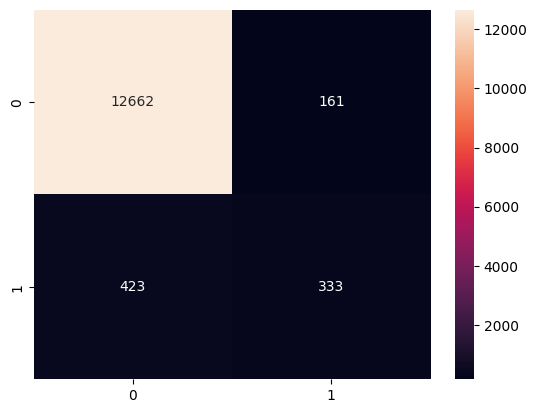

In [24]:
#confusion matrix 12SL (no model)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(y_test, y_12SL)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()


#confusion matrix (from model)


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

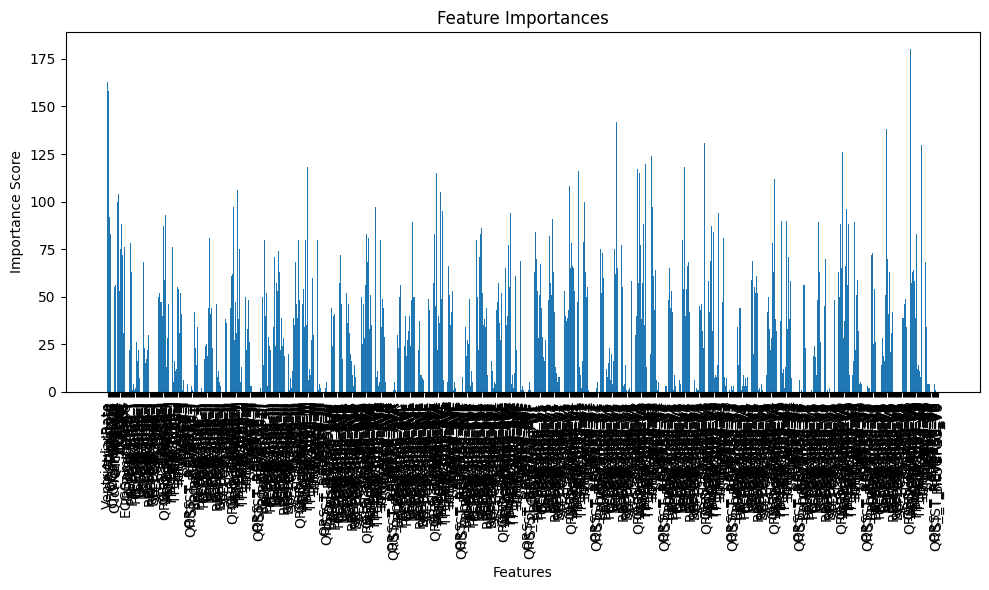

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'model' is your trained LightGBM model
importances = model.feature_importances_
feature_names = X_train.columns if hasattr(X_train, 'columns') else np.arange(len(importances))

# Create a bar plot of the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances)
plt.xticks(range(len(importances)), feature_names, rotation='vertical')
plt.title("Feature Importances")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()


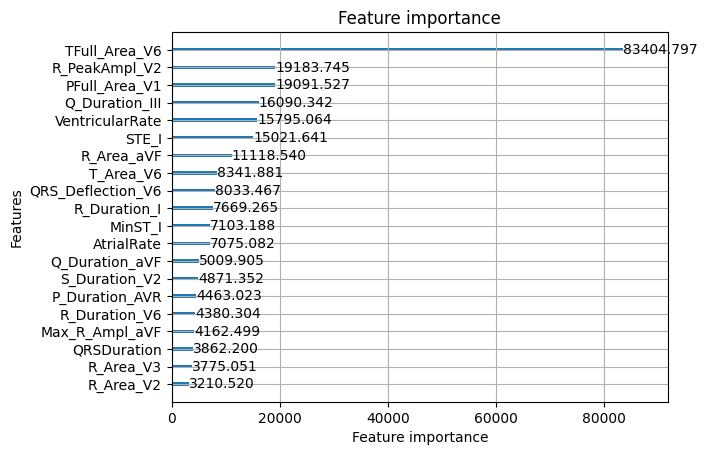

In [26]:
# 'gbm' is the model returned by lgb.train
booster = model.booster_
importances = booster.feature_importance(importance_type='split')  # or use 'gain'
feature_names = booster.feature_name()

lgb.plot_importance(booster, importance_type='gain', max_num_features=20)
plt.show()


Number of components selected: 274
Total variance explained: 0.9503453841986094
Variance explained by each component: [0.07138166 0.05686371 0.04651962 0.03863669 0.03403071 0.03045029
 0.02510098 0.02220052 0.01942213 0.01763596 0.01618436 0.01538212
 0.01496859 0.01369802 0.01235228 0.01172646 0.01078413 0.01019476
 0.01004691 0.00909832 0.00857864 0.0077722  0.00763337 0.00757727
 0.0074205  0.00698402 0.006312   0.0062756  0.00618439 0.00606509
 0.00586477 0.00578576 0.00570109 0.00538757 0.00515766 0.0049998
 0.0049767  0.00478553 0.00471745 0.00458615 0.00450613 0.00445425
 0.0044031  0.00418683 0.00414715 0.00413401 0.00404325 0.00398036
 0.00387204 0.00382811 0.00375094 0.00371143 0.00360146 0.00356537
 0.00347347 0.0034569  0.00341657 0.00336607 0.00328691 0.00322449
 0.00321342 0.00318444 0.00313293 0.00308112 0.00300817 0.00297644
 0.00294341 0.00290395 0.00286511 0.00283157 0.00279622 0.00275637
 0.0027179  0.00269842 0.00266425 0.00263372 0.00263206 0.00254832
 0.00252495 

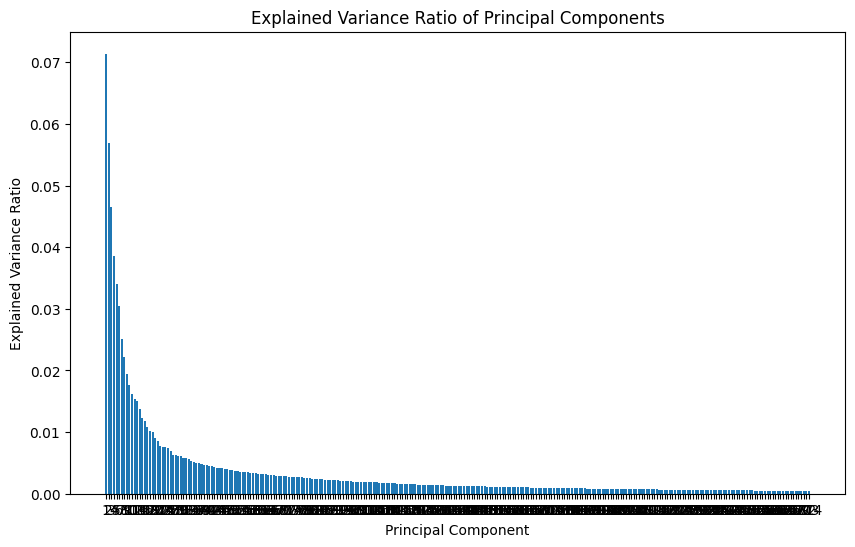

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_cols = df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT', 'MI_Phys'])
# drop NaN values
df_cols = df_cols.dropna()
X_scaled = scaler.fit_transform(df_cols)

pca = PCA(n_components=0.95, random_state=42)  # keep 95% of variance
principal_components = pca.fit_transform(X_scaled)

print("Number of components selected:", pca.n_components_)
print("Total variance explained:", pca.explained_variance_ratio_.sum())
print("Variance explained by each component:", pca.explained_variance_ratio_)
print("Principal components shape:", principal_components.shape)
#column names from original data
feature_names = df_cols.columns
# Create a DataFrame with the principal components
df_pca = pd.DataFrame(data=principal_components, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_)
plt.title("Explained Variance Ratio of Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, pca.n_components_ + 1))
plt.show()

In [28]:
df_cols_Y = df.drop(columns=['PatientID', '12SL_Codes', 'Phys_Codes','TestID', 'Source', 'MI_12SL', 'Gender', 'PatientAge', 'AcquisitionDateTime_DT'])
# drop NaN values
df_cols_Y = df_cols_Y.dropna()
y = df_cols_Y['MI_Phys']
X_train, X_test, y_train, y_test = train_test_split(df_pca, y, test_size=0.2, random_state=42)
#count number of positive and negative smales based on MI_Phys
print(df_cols_Y['MI_Phys'].value_counts())



MI_Phys
0    50935
1     3239
Name: count, dtype: int64


In [29]:
estimators = [0.25, 0.2, 0.15, 0.1, 0.09]
leaves = [15, 31, 63, 127]
scores = {}
for estims in estimators:
    for num_leaves in leaves:
        lgb_params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'n_estimators': 100,
            'learning_rate': estims,
            'random_state': 42,
            'verbose': -1,
            'num_leaves': num_leaves,
            
            }
        model = (lgb.LGBMClassifier(**lgb_params))
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = f1_score(y_test, y_pred, average='micro')
        scores[(estims, num_leaves)] = score
        print(f"Learning rate: {estims}, Number of Leaves: {num_leaves} F1 score: {score:.4f}")

Learning rate: 0.25, Number of Leaves: 15 F1 score: 0.9401
Learning rate: 0.25, Number of Leaves: 31 F1 score: 0.9410
Learning rate: 0.25, Number of Leaves: 63 F1 score: 0.9427
Learning rate: 0.25, Number of Leaves: 127 F1 score: 0.9452
Learning rate: 0.2, Number of Leaves: 15 F1 score: 0.9435
Learning rate: 0.2, Number of Leaves: 31 F1 score: 0.9432
Learning rate: 0.2, Number of Leaves: 63 F1 score: 0.9434
Learning rate: 0.2, Number of Leaves: 127 F1 score: 0.9451
Learning rate: 0.15, Number of Leaves: 15 F1 score: 0.9454
Learning rate: 0.15, Number of Leaves: 31 F1 score: 0.9429
Learning rate: 0.15, Number of Leaves: 63 F1 score: 0.9439
Learning rate: 0.15, Number of Leaves: 127 F1 score: 0.9453
Learning rate: 0.1, Number of Leaves: 15 F1 score: 0.9443
Learning rate: 0.1, Number of Leaves: 31 F1 score: 0.9451
Learning rate: 0.1, Number of Leaves: 63 F1 score: 0.9457
Learning rate: 0.1, Number of Leaves: 127 F1 score: 0.9459
Learning rate: 0.09, Number of Leaves: 15 F1 score: 0.9452
L

In [30]:
lgb_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'n_estimators': 200,
    'learning_rate': 0.15,
    'random_state': 42,
    'verbose': -1,
    'num_leaves': 127,
    'scale_pos_weight': 50935/3239,
    #'is_unbalance': True

    }
model = (lgb.LGBMClassifier(**lgb_params))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='micro')
print("Final F1 score: ", score)


Final F1 score:  0.946285186894324


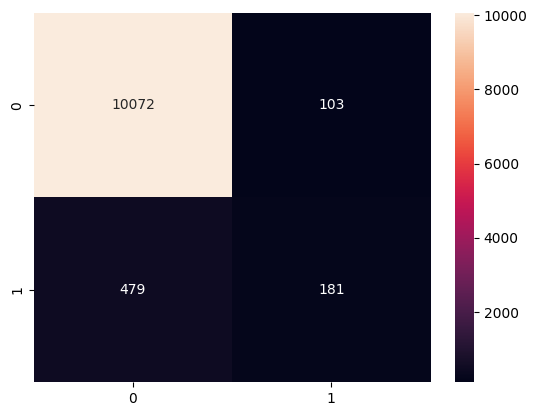

In [31]:
#confusion matrix 12SL (no model)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# cm = confusion_matrix(y_test, y_12SL)
# sns.heatmap(cm, annot=True, fmt='d')
# plt.show()


#confusion matrix (from model)


cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [32]:
from imblearn.over_sampling import SMOTE

# Rebalance training data using SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
#do not use this, here just to see the data distribution
print("Before SMOTE class distribution:\n", y_train.value_counts())
print("After SMOTE class distribution:\n", y_train_bal.value_counts())

Before SMOTE class distribution:
 MI_Phys
0    40760
1     2579
Name: count, dtype: int64
After SMOTE class distribution:
 MI_Phys
0    40760
1    40760
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, classification_report, fbeta_score
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd

# Define base models (use 1 linear to make it diverse)
base_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('lgbm', LGBMClassifier(n_estimators=200, learning_rate=0.15, num_leaves=127, random_state=42)),
    ('logreg', LogisticRegression(max_iter=1000, random_state=42))
]

# Define meta model (stacking model)
meta_model = LGBMClassifier(n_estimators=50, learning_rate=0.05, random_state=42)

# Stacking ensemble with passthrough
stacked_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_model,
    cv=5,
    passthrough=False,
    n_jobs=-1
)

# Fit and evaluate
stacked_model.fit(X_train, y_train)
# This keeps feature names consistent
y_pred_stack = stacked_model.predict(pd.DataFrame(X_test, columns=X_train.columns))
f1_stack_micro = f1_score(y_test, y_pred_stack, average='micro')
f1_stack_macro = f1_score(y_test, y_pred_stack, average='macro')

print("Stacked Ensemble (RF + LGBM + Logistic) F1 Score Micro:", f1_stack_micro)
print("Stacked Ensemble (RF + LGBM + Logistic) F1 Score Macro:", f1_stack_macro)

In [ ]:
from sklearn.metrics import classification_report

print("=== LightGBM ===")
print(classification_report(y_test, y_pred))

print("=== Stacking (RF + LGBM + Logistic) ===")
print(classification_report(y_test, y_pred_stack))


=== LightGBM ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10175
           1       0.64      0.27      0.38       660

    accuracy                           0.95     10835
   macro avg       0.80      0.63      0.68     10835
weighted avg       0.94      0.95      0.94     10835

=== Stacking (RF + LGBM + Logistic) ===
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     10175
           1       0.65      0.24      0.35       660

    accuracy                           0.95     10835
   macro avg       0.80      0.62      0.66     10835
weighted avg       0.93      0.95      0.93     10835

